In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, t, laplace
import seaborn as sns
import os, wget, shutil
from rich import print

os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)
clean_data = data[~np.isnan(data)]

100% [..........................................................] 39886 / 39886

Original file downloaded.

In [2]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output

def dp(clean_data,pipeline_output):

    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    while True:
        noise = np.random.laplace(loc=0.0, scale=loo_scale)
        if abs(noise) >= sensitivity:
            break

    noisy_output = pipeline_output + noise
    return noisy_output, sensitivity


def dp_2(data):

    loo_means = np.array([np.mean(np.delete(data, i)) for i in range(len(data))])
    loo_stds = np.array([np.std(np.delete(data, i), ddof=1) for i in range(len(data))])
    mean_sensitivity = np.max(np.abs(loo_means - np.mean(data)))
    std_sensitivity = np.max(np.abs(loo_stds - np.std(data, ddof=1)))
    
    while True:
        noise_mean = np.random.laplace(loc=0.0, scale=mean_sensitivity)
        noise_std = np.random.laplace(loc=0.0, scale=std_sensitivity)

        if abs(noise_mean) >= mean_sensitivity and abs(noise_std) >= std_sensitivity:
            break
            
    return noise_mean, noise_std, mean_sensitivity, std_sensitivity


def user_output_loo_stats(clean_data):
    
    loo_mean = np.array([np.mean(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_std = np.std(loo_mean, ddof=1)#np.sqrt(np.sum((clean_data - loo_mean) ** 2) / len(clean_data) - 1)
    loo_t = loo_mean / (loo_std / np.sqrt(len(clean_data) - 1))

    return loo_mean, loo_std, loo_t


In [16]:
np.random.seed(42)
null_true_mu = 170
std_dev = 10
alpha_ = [0.01, 0.05, 0.1]
effect_sizes = [0, 0.2, 0.5, 0.8, 1.0]  
n_simulations = 100
sample_sizes = [50, 100]#[20, 40, 60, 80, 100]
results = list()

for size in sample_sizes:
    for alpha in alpha_:
        for effect in effect_sizes:
            type_I_u = 0
            type_I_n = 0
            power_u = 0
            power_n = 0
            sensitivities = []
            for _ in range(n_simulations):
                true_mean = null_true_mu if effect == 0 else null_true_mu + effect*std_dev
                data = np.random.normal(loc=true_mean, scale=std_dev, size=size)
                
                loo_data = np.array([np.delete(data, i) for i in range(len(data))])
                sample_mean = np.mean(loo_data)
                sample_std = np.std(loo_data, ddof=1)
                loo_mu = np.array([user_output(loo_subset) for loo_subset in loo_data])
                    
                _, p_loo = ttest_1samp(loo_mu, null_true_mu)

                ######## PIPELINE ########
                noisy_outputs = []
                sens_outputs = []
                for loo_subset in loo_data:
                    output = user_output(loo_subset)
                    noisy_output, sensitivity_ = dp(loo_subset, output)
                    noisy_outputs.append(noisy_output)
                    sens_outputs.append(sensitivity_)
                
                _, p_loo_n = ttest_1samp(noisy_outputs, null_true_mu)

                if effect == 0: 
                    type_I_u += (p_loo < alpha)
                    type_I_n += (p_loo_n < alpha)
                else:  
                    power_u += (p_loo < alpha)
                    power_n += (p_loo_n < alpha)
                
                sensitivities.append(sensitivity_)
            

            results.append({
                'sample_size': size,
                'alpha': alpha,
                'effect_size': effect,
                'type_I_standard': type_I_u/n_simulations if effect == 0 else np.nan,
                'type_I_noised': type_I_n/n_simulations if effect == 0 else np.nan,
                'power_standard': power_u/n_simulations if effect != 0 else np.nan,
                'power_noised': power_n/n_simulations if effect != 0 else np.nan,
                'sensitivity': np.mean([s for s in sensitivities])})


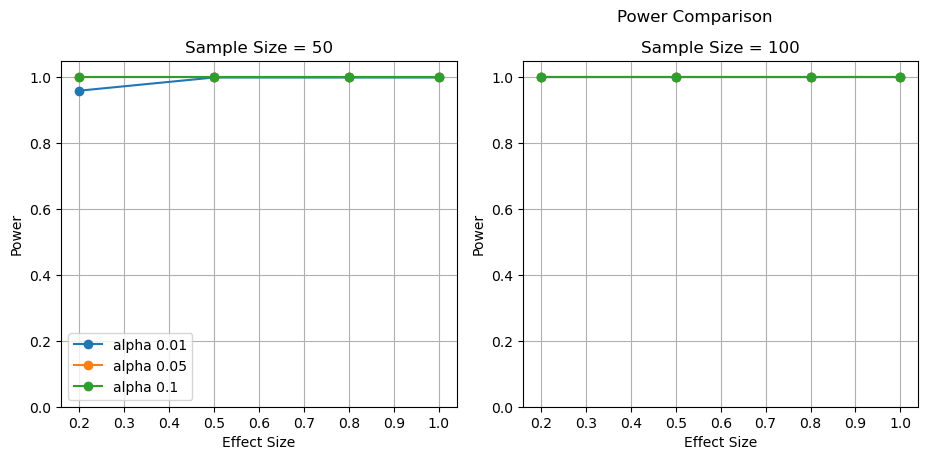

In [17]:
df = pd.DataFrame(results)

plt.figure(figsize=(14, 8))
alpha_ = [0.01, 0.05, 0.1]
for i, size in enumerate(sample_sizes):
    plt.subplot(2, 3, i+1)
    al1 = df[(df['alpha'] == alpha_[0]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al2 = df[(df['alpha'] == alpha_[1]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al3 = df[(df['alpha'] == alpha_[2]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    
    plt.plot(al1['effect_size'], al1['power_standard'], 'o-', label='alpha 0.01')
    plt.plot(al2['effect_size'], al2['power_standard'], 'o-', label='alpha 0.05')
    plt.plot(al3['effect_size'], al3['power_standard'], 'o-', label='alpha 0.1')
       
    plt.xlabel('Effect Size')
    plt.ylabel('Power')
    plt.title(f'Sample Size = {size}')
    plt.ylim(0, 1.05)
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle(f'Power Comparison', y=1.02)
plt.show()




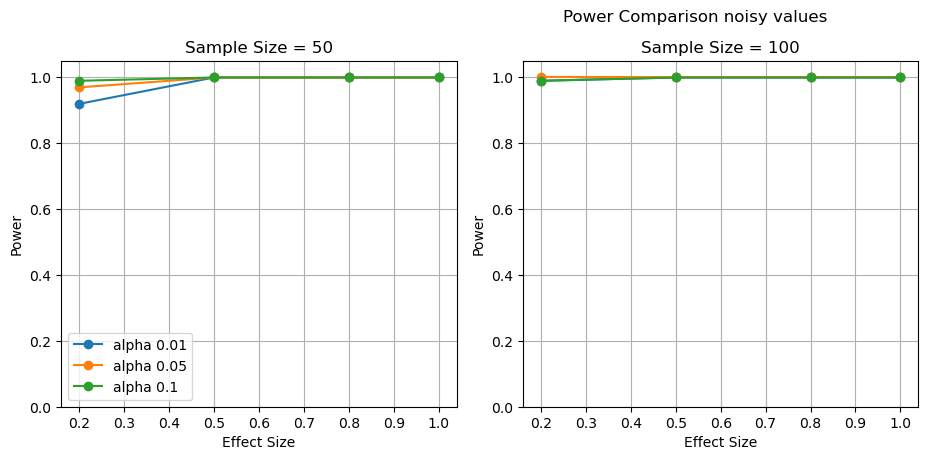

In [18]:
df = pd.DataFrame(results)

plt.figure(figsize=(14, 8))
alpha_ = [0.01, 0.05, 0.1]
for i, size in enumerate(sample_sizes):
    plt.subplot(2, 3, i+1)
    al1 = df[(df['alpha'] == alpha_[0]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al2 = df[(df['alpha'] == alpha_[1]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al3 = df[(df['alpha'] == alpha_[2]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    
    plt.plot(al1['effect_size'], al1['power_noised'], 'o-', label='alpha 0.01')
    plt.plot(al2['effect_size'], al2['power_noised'], 'o-', label='alpha 0.05')
    plt.plot(al3['effect_size'], al3['power_noised'], 'o-', label='alpha 0.1')
       
    plt.xlabel('Effect Size')
    plt.ylabel('Power')
    plt.title(f'Sample Size = {size}')
    plt.ylim(0, 1.05)
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle(f'Power Comparison noisy values', y=1.02)
plt.show()




In [ ]:

plt.figure(figsize=(10, 6))
plt.hist(p_n, bins=50, alpha=0.6, label='Null Hypothesis (True)', color='blue')
plt.hist(p_a, bins=50, alpha=0.6, label='Alternative Hypothesis (True)', color='red')
plt.axvline(alpha, color='black', linestyle='--', label=f'Significance Level (alpha = {alpha})')
plt.title('Distribution of P-values Under Null and Alternative Hypotheses')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
list(df["type_I_noised"])

[0.86,
 nan,
 nan,
 nan,
 nan,
 0.87,
 nan,
 nan,
 nan,
 nan,
 0.91,
 nan,
 nan,
 nan,
 nan,
 0.89,
 nan,
 nan,
 nan,
 nan,
 0.93,
 nan,
 nan,
 nan,
 nan,
 0.96,
 nan,
 nan,
 nan,
 nan]

In [213]:
def calc_sens(data):
    loo_means = np.array([np.mean(np.delete(data, i)) for i in range(len(data))])
    loo_stds = np.array([np.std(np.delete(data, i), ddof=1) for i in range(len(data))])
    mean_sensitivity = np.max(np.abs(loo_means - np.mean(data)))
    std_sensitivity = np.max(np.abs(loo_stds - np.std(data, ddof=1)))
    
    return mean_sensitivity, std_sensitivity

def add_noise(clean_data, pipeline_mean, pipeline_std):
    
    mean_sens, std_sens = calc_sens(clean_data)
    noisy_mean = pipeline_mean + np.random.laplace(loc=0, scale=mean_sens)
    noisy_std = pipeline_std + np.random.laplace(loc=0, scale=std_sens)
    noisy_std = max(noisy_std, 0.1)  
    
    return noisy_mean, noisy_std, mean_sens, std_sens

In [229]:
np.random.seed(42)
null_true_mu = 170
std_dev = 10
sample_sizes = [10, 20, 30, 50, 100]
alpha_ = [0.01, 0.05, 0.1, 1.0]
effect_sizes = [0, 0.2, 0.5, 0.8, 1.0]  
n_simulations = 1000 

results = []
for size in sample_sizes:
    for alpha in alpha_:
        for effect in effect_sizes:
            type_I_standard = 0
            type_I_dp_mean_only = 0
            type_I_dp_mean_std = 0
            power_standard = 0
            power_dp_mean_only = 0
            power_dp_mean_std = 0
            sensitivities = []
            
            for _ in range(n_simulations):
                true_mean = null_true_mu if effect == 0 else null_true_mu + effect*std_dev
                data = np.random.normal(loc=true_mean, scale=std_dev, size=size)
                _, p_standard = ttest_1samp(data, null_true_mu)
                sample_mean = np.mean(data)
                sample_std = np.std(data, ddof=1)

                noisy_mean1, _, mean_sens, _ = add_noise(data, sample_mean, sample_std)
                t_mean_only = noisy_mean1 / (sample_std/np.sqrt(size))
                p_mean_only = 2 * (1 - t.cdf(abs(t_mean_only), df=size-1))
                
                noisy_mean2, noisy_std2, mean_sens, std_sens = add_noise(data, sample_mean, sample_std)
                t_mean_std = noisy_mean2 / (noisy_std2/np.sqrt(size))
                p_mean_std = 2 * (1 - t.cdf(abs(t_mean_std), df=size-1))
                
                if effect == 0: 
                    type_I_standard += (p_standard < alpha)
                    type_I_dp_mean_only += (p_mean_only < alpha)
                    type_I_dp_mean_std += (p_mean_std < alpha)
                else:  
                    power_standard += (p_standard < alpha)
                    power_dp_mean_only += (p_mean_only < alpha)
                    power_dp_mean_std += (p_mean_std < alpha)
                
                sensitivities.append((mean_sens, std_sens))
            

            results.append({
                'sample_size': size,
                'alpha': alpha,
                'effect_size': effect,
                'type_I_standard': type_I_standard/n_simulations if effect == 0 else np.nan,
                'type_I_dp_mean_only': type_I_dp_mean_only/n_simulations if effect == 0 else np.nan,
                'type_I_dp_mean_std': type_I_dp_mean_std/n_simulations if effect == 0 else np.nan,
                'power_standard': power_standard/n_simulations if effect != 0 else np.nan,
                'power_dp_mean_only': power_dp_mean_only/n_simulations if effect != 0 else np.nan,
                'power_dp_mean_std': power_dp_mean_std/n_simulations if effect != 0 else np.nan,
                'mean_sensitivity': np.mean([s[0] for s in sensitivities]),
                'std_sensitivity': np.mean([s[1] for s in sensitivities])
            })


In [216]:
df = pd.DataFrame(results)

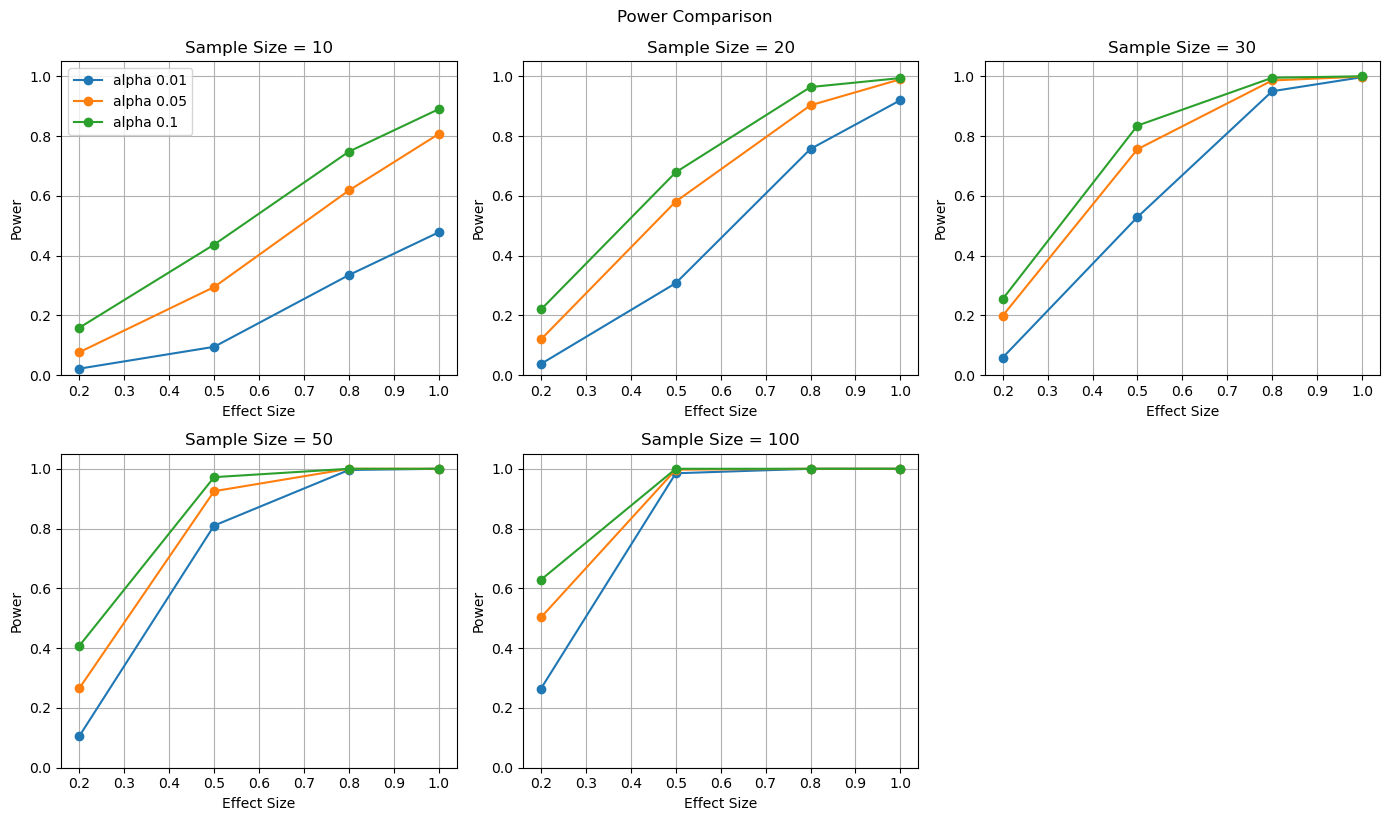

In [233]:
plt.figure(figsize=(14, 8))
alpha_ = [0.01, 0.05, 0.1]
for i, size in enumerate(sample_sizes):
    plt.subplot(2, 3, i+1)
    al1 = df[(df['alpha'] == alpha_[0]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al2 = df[(df['alpha'] == alpha_[1]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    al3 = df[(df['alpha'] == alpha_[2]) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    
    plt.plot(al1['effect_size'], al1['power_standard'], 'o-', label='alpha 0.01')
    plt.plot(al2['effect_size'], al2['power_standard'], 'o-', label='alpha 0.05')
    plt.plot(al3['effect_size'], al3['power_standard'], 'o-', label='alpha 0.1')
       
    plt.xlabel('Effect Size')
    plt.ylabel('Power')
    plt.title(f'Sample Size = {size}')
    plt.ylim(0, 1.05)
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle(f'Power Comparison', y=1.02)
plt.show()




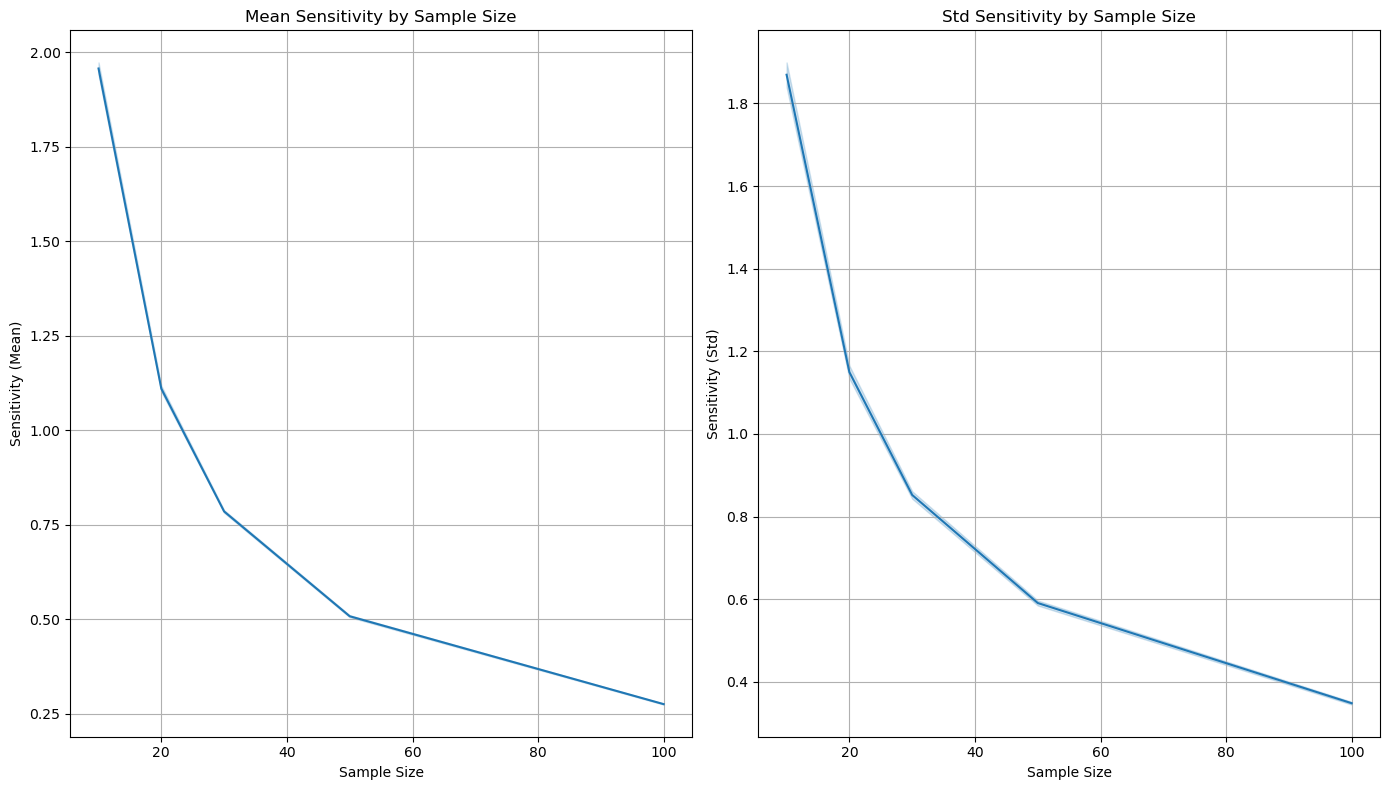

In [226]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.lineplot(x='sample_size', y='mean_sensitivity', data=df, errorbar='sd')
plt.title('Mean Sensitivity by Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Sensitivity (Mean)')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(x='sample_size', y='std_sensitivity', data=df, errorbar='sd')
plt.title('Std Sensitivity by Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Sensitivity (Std)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [227]:
print("Type I Error Rates Summary:")
print()
print(df[df['effect_size'] == 0].groupby(['alpha', 'sample_size'])[
    ['type_I_standard', 'type_I_dp_mean_only', 'type_I_dp_mean_std']].mean())

print("\nPower Comparison Summary (alpha=0.05):")
print(df[(df['alpha'] == 0.05) & (df['effect_size'] != 0)].groupby(['effect_size', 'sample_size'])[
    ['power_standard', 'power_dp_mean_only', 'power_dp_mean_std']].mean())

print("\nAverage Sensitivities:")
print(df.groupby('sample_size')[['mean_sensitivity', 'std_sensitivity']].mean())

Type I Error Rates Summary:

type_I_standard  type_I_dp_mean_only  type_I_dp_mean_std
alpha sample_size                                                          
0.01  10                     0.010                  1.0                 1.0
      20                     0.013                  1.0                 1.0
      30                     0.011                  1.0                 1.0
      50                     0.010                  1.0                 1.0
      100                    0.007                  1.0                 1.0
0.05  10                     0.060                  1.0                 1.0
      20                     0.037                  1.0                 1.0
      30                     0.064                  1.0                 1.0
      50                     0.042                  1.0                 1.0
      100                    0.058                  1.0                 1.0
0.10  10                     0.100                  1.0                 1.0
      20                     0.111                  1.0                 1.0
      30                     0.100                  1.0                 1.0
      50                     0.092                  1.0                 1.0
      100                    0.108                  1.0                 1.0

Power Comparison Summary (alpha=0.05):

power_standard  power_dp_mean_only  power_dp_mean_std
effect_size sample_size                                                       
0.2         10                    0.077                 1.0                1.0
            20                    0.120                 1.0                1.0
            30                    0.199                 1.0                1.0
            50                    0.266                 1.0                1.0
            100                   0.503                 1.0                1.0
0.5         10                    0.295                 1.0                1.0
            20                    0.581                 1.0                1.0
            30                    0.756                 1.0                1.0
            50                    0.925                 1.0                1.0
            100                   0.997                 1.0                1.0
0.8         10                    0.618                 1.0                1.0
            20                    0.903                 1.0                1.0
            30                    0.986                 1.0                1.0
            50                    1.000                 1.0                1.0
            100                   1.000                 1.0                1.0
1.0         10                    0.807                 1.0                1.0
            20                    0.990                 1.0                1.0
            30                    0.999                 1.0                1.0
            50                    1.000                 1.0                1.0
            100                   1.000                 1.0                1.0

Average Sensitivities:

mean_sensitivity  std_sensitivity
sample_size                                   
10                   1.957005         1.869581
20                   1.110203         1.149618
30                   0.785569         0.852225
50                   0.508444         0.590662
100                  0.275990         0.348006